In [1]:
import gzip
import numpy
import json
import matplotlib.pyplot as plot
import AGG

In [2]:
crossmap = '/home/suhang/newdisk/mito_ccs_read_analyzer/output/crossmap_queries.names'

In [6]:
def loadFasta(filename):
    """ Parses a classically formatted and possibly 
        compressed FASTA file into a list of headers 
        and fragment sequences for each sequence contained.
        The resulting sequences are 0-indexed! """
    if (filename.endswith(".gz")):
        fp = gzip.open(filename, 'rb')
    else:
        fp = open(filename, 'rb')
    # split at headers
    data = fp.read().decode().split('>')
    fp.close()
    # ignore whatever appears before the 1st header
    data.pop(0)     
    headers = []
    sequences = []
    for sequence in data:
        lines = sequence.split('\n')
        headers.append(lines.pop(0))
        sequences.append(''.join(lines))
    return (headers, sequences)

def loadFastq(filename):
    """ Parses a classically formatted and possibly 
        compressed FASTA file into a list of headers 
        and fragment sequences for each sequence contained.
        The resulting sequences are 0-indexed! """
    if (filename.endswith(".gz")):
        fp = gzip.open(filename, 'rb')
    else:
        fp = open(filename, 'rb')
    # split at headers
    data = fp.read().decode().split('@')
    fp.close()
    # ignore whatever appears before the 1st header
    data.pop(0)     
    headers = []
    sequences = []
    for sequence in data:
        lines = sequence.split('\n')
        if len(lines) == 4:
            headers.append(lines[0])
            sequences.append(lines[1])
    return (headers, sequences)

def writeFasta(filename, header, sequence, length = 60):
    with open(filename, 'w') as fp:
        for i, h in enumerate(header):
            fp.write(">" + h + "\n")
            seq = sequence[i]
            l = len(seq)//length
            for i in range(l):
                fp.write(seq[i*length:(i+1)*length] + '\n')
            fp.write(seq[(i+1)*length:] + '\n')

In [7]:
headers, sequences = loadFasta('/home/suhang/assembly_disk/Mitochondrial/HPRC_46/kmer31/all.fasta')
#headers, sequences = loadFastq("/home/suhang/newdisk/mito_ccs_read_analyzer/output/Bifrost_k31_46sample.fastq.gz")

In [8]:
len(sequences[0]), len(headers) == len(sequences), len(headers)

(8286, True, 11922)

In [12]:
#headers
# len(crossmap)
len(set(headers) & set(readnames))

0

In [13]:
for h in headers:
    if h == 'm54329U_190607_185248/140444542/ccs':
        print(h)

In [14]:
with open(crossmap, 'r') as fp:
    data = fp.readlines()
readnames = [r[:-1] for r in data]
len(set(readnames) & set(headers))

0

In [15]:
readnames = set(readnames)
len(set(readnames))

1173

In [16]:
indexlist = []
for i, h in enumerate(headers):
    nh = "_".join(h.split("_")[:-1])
    if nh in readnames:
        indexlist.append(i)
len(indexlist)

296

In [17]:
newheaders = [headers[i] for i in indexlist]
newsequences = [sequences[i] for i in indexlist]

In [18]:
writeFasta('numts296.fasta', newheaders, newsequences, length = 60)

# graphs

In [19]:
filename = './test.gfa'
graph = AGG.GraphicalGenome(filename)

In [20]:
edgelist = graph.edges.keys()
subgraph_edge = {}

for edge in edgelist:
    readset =  graph.edges[edge]['reads']
    readset = set(["_".join(read.split("_")[:-1]) for read in readset])
    if len(readset & readnames) > 1:
        subgraph_edge[edge] = graph.edges[edge]
        subgraph_edge[edge]['reads'] = list(readset & readnames)

In [21]:
graph.edges['E00000.0001'].keys(), graph.anchor['A000001'].keys()

(dict_keys(['reads', 'strain', 'seq']), dict_keys(['pos', 'seq']))

In [29]:
R_set = set(newheaders)

In [30]:
edgelist = sorted(graph.edges.keys())
numts_readname = []
for edge in edgelist:
    reads = graph.edges[edge]['reads']
    if len(set(reads) & R_set)>0:
        numts_readname.append(edge)

In [33]:
numts_read_num = [len(graph.edges[edge]['reads']) for edge in numts_readname]
all_read_num = [len(graph.edges[edge]['reads']) for edge in edgelist]

/tmp/ipykernel_20072/220152591.py:4: RuntimeWarning: divide by zero encountered in log10
  plot.plot(x[:-1], numpy.log10(y))
/tmp/ipykernel_20072/220152591.py:5: RuntimeWarning: divide by zero encountered in log10
  plot.plot(x1[:-1], numpy.log10(y1))


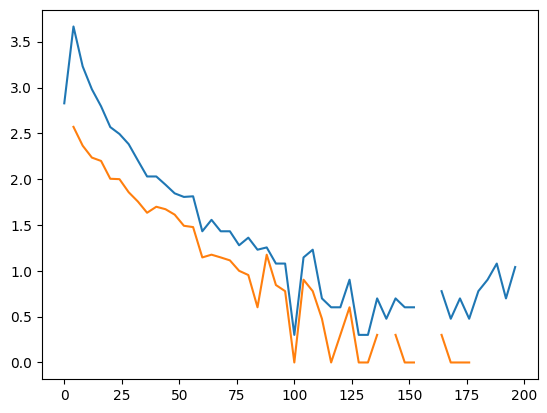

In [45]:
y,x = numpy.histogram(all_read_num, range = [0,200], bins = 50)
y1, x1 = numpy.histogram(numts_read_num, range = [0,200], bins = 50)

plot.plot(x[:-1], numpy.log10(y))
plot.plot(x1[:-1], numpy.log10(y1))

In [22]:
# write_gfa(graph, graph.anchor, subgraph_edge, "./numts.gfa")